In [11]:
# -*- coding: utf-8 -*-
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the mems dataset.
# implemented Adavance Ensamble Learning Techniques: Stacking

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import time



In [12]:
# Load mems dataset
df = pd.read_csv('/home/ibibers@ads.iu.edu/IOT/IOT_Datasets/mems_dataset.csv')

# Drop duplicates
df = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value
one_value = df.columns[df.nunique() == 1]
df = df.drop(columns = one_value, axis=1)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 21563 entries, 0 to 21575
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       21563 non-null  float64
 1   y       21563 non-null  float64
 2   z       21563 non-null  float64
 3   label   21563 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 842.3 KB


In [13]:
# X-axis: Represents acceleration along the horizontal axis.
# Y-axis: Represents acceleration along the vertical axis.
# Z-axis: Represents acceleration along the depth axis.

# labels 
#1. Normal: This label represents the state of the machine when it is operating under normal conditions, without any significant mechanical imbalance or impending failure.
#2. Near-failure: This label indicates that the machine is experiencing conditions that suggest it is close to a failure state. These conditions may include early signs of mechanical imbalance or other issues that could lead to failure if not addressed.
#3. Failure: This label is assigned when the machine has reached a state of failure, where it is no longer functioning as intended due to mechanical issues or other problems.

# Extract subsample of data
print (" Extract subsample of data: ")
print(df['label'].value_counts())

 Extract subsample of data: 
label
1    10955
2     5771
3     4837
Name: count, dtype: int64


In [14]:
dropped_df = ['label']
X = df.drop(dropped_df, axis=1)
y = df['label']


In [15]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dimensionality Reduction using PCA
# # pca = PCA(n_components=0.95)
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
svc_model = SVC(kernel='rbf', probability=True)  
lr_model = LogisticRegression(solver='lbfgs', multi_class='multinomial')  
knn_model = KNeighborsClassifier()

# # Build a pipeline for each model with PCA
# rf_pipeline = Pipeline([('pca', PCA(n_components=0.95)), ('rf', rf_model)])
# svc_pipeline = Pipeline([('pca', PCA(n_components=0.95)), ('nn', svc_model)])
# lr_pipeline = Pipeline([('pca', PCA(n_components=0.95)), ('lr', lr_model)])
# knn_pipeline = Pipeline([('pca', PCA(n_components=0.95)), ('dst', knn_model)])

meta_model = SVC(kernel='rbf', probability=True)  

from sklearn.ensemble import StackingClassifier
# Stack models using StackingClassifier

  # Stack models using LightGBM
stacked_model = StackingClassifier(estimators=[
    ('rf', rf_model),
    ('svc', svc_model),
    ('lr', lr_model),
    ('knn', knn_model),
], final_estimator=meta_model)

start_train_time = time.time()
stacked_model.fit(X_train, y_train)
train_time = time.time() - start_train_time

start_pred_time = time.time()  
y_pred = stacked_model.predict(X_test)
pred_time = time.time() - start_pred_time

total_time = time.time() - start_time


/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

In [16]:
print("Time taken for training:{:f} seconds".format(train_time))
print("Time taken for prediction: {:f} seconds".format(pred_time))
print("Total time taken:{:f} seconds".format(total_time))

Time taken for training:149.271045 seconds
Time taken for prediction: 4.350584 seconds
Total time taken:153.628100 seconds


In [17]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7067552944813728


In [18]:


# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.87      0.76      3283
           2       0.80      0.78      0.79      1696
           3       0.71      0.26      0.38      1490

    accuracy                           0.71      6469
   macro avg       0.73      0.64      0.64      6469
weighted avg       0.71      0.71      0.68      6469



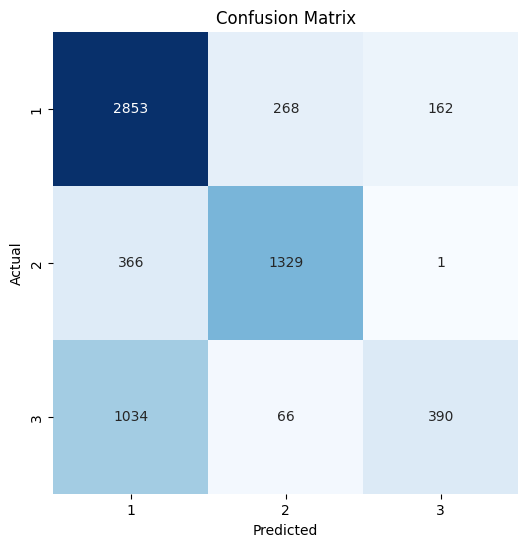

In [19]:
# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test, y_pred)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate(
    (y_test, y_pred)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_7462/2485561238.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance.values,


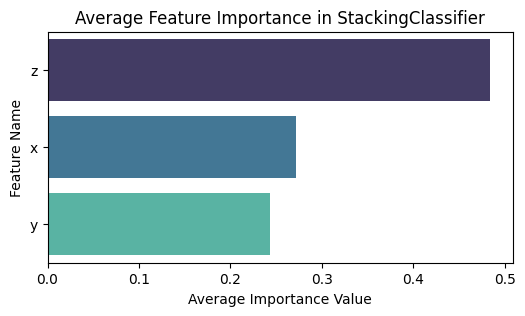

In [21]:
# Extract feature importances from base models
base_models_importances = {}

for name, model in stacked_model.named_estimators_.items():
    if hasattr(model, 'feature_importances_'):
        base_models_importances[name] = model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame(base_models_importances, index=X.columns)

# Calculate average feature importance across base models
average_importance = importance_df.mean(axis=1)

# Sort features by average importance
sorted_importance = average_importance.sort_values(ascending=False)

# Visualize the feature importances
plt.figure(figsize=(6, 3))
sns.barplot(x=sorted_importance.values,
            y=sorted_importance.index, palette='mako')
plt.xlabel('Average Importance Value')
plt.ylabel('Feature Name')
plt.title('Average Feature Importance in StackingClassifier')
plt.show()